In [5]:
# Celda para subir tu NUEVO y SEGURO archivo kaggle.json
from google.colab import files
import os

print("Por favor, sube tu NUEVO archivo kaggle.json")
uploaded = files.upload()

# El resto del código para configurar la API
if 'kaggle.json' in uploaded:
    os.makedirs('/root/.kaggle', exist_ok=True)
    os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 600)
    print("✅ ¡API de Kaggle configurada exitosamente con tu nueva clave!")
else:
    print("❌ Error: No se encontró el archivo kaggle.json.")

Por favor, sube tu NUEVO archivo kaggle.json


❌ Error: No se encontró el archivo kaggle.json.


In [6]:
# Celda 2: Instalar/actualizar kagglehub y descargar el dataset
!pip install --upgrade kagglehub

import kagglehub
import os

print("Descargando el dataset con kagglehub...")
# Esta función descarga y descomprime el dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print(f"Dataset descargado y descomprimido en la ruta: {path}")

# --- IMPORTANTE ---
# Ahora, creamos las variables que apuntan a las carpetas de datos
train_dir = os.path.join(path, 'chest_xray/train')
val_dir = os.path.join(path, 'chest_xray/val')
test_dir = os.path.join(path, 'chest_xray/test')

print("\nRutas listas para el modelo:")
print(f"Entrenamiento: {train_dir}")
print(f"Validación: {val_dir}")
print(f"Prueba: {test_dir}")

Descargando el dataset con kagglehub...
Dataset descargado y descomprimido en la ruta: /kaggle/input/chest-xray-pneumonia

Rutas listas para el modelo:
Entrenamiento: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Validación: /kaggle/input/chest-xray-pneumonia/chest_xray/val
Prueba: /kaggle/input/chest-xray-pneumonia/chest_xray/test


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

¡Generadores de datos listos!


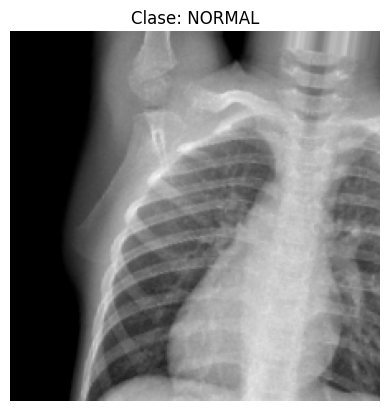

In [7]:
# Celda 3: Importar bibliotecas y crear generadores de imágenes
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# --- PARÁMETROS ---
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# --- GENERADOR PARA DATOS DE ENTRENAMIENTO (CON AUMENTO DE DATOS) ---
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normaliza los píxeles de 0-255 a 0-1
    rotation_range=20,         # Gira la imagen aleatoriamente hasta 20 grados
    width_shift_range=0.2,     # Desplaza la imagen horizontalmente
    height_shift_range=0.2,    # Desplaza la imagen verticalmente
    shear_range=0.2,           # Inclina la imagen
    zoom_range=0.2,            # Hace zoom aleatorio
    horizontal_flip=True,      # Invierte la imagen horizontalmente
    fill_mode='nearest'        # Rellena píxeles nuevos con los más cercanos
)

# --- GENERADOR PARA DATOS DE VALIDACIÓN Y PRUEBA (SOLO NORMALIZACIÓN) ---
# ¡Nunca aplicamos aumento de datos a los conjuntos de validación o prueba!
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# --- CREAR LOS GENERADORES DESDE LOS DIRECTORIOS ---
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary', # Clasificación binaria: NORMAL vs PNEUMONIA
    color_mode='rgb'     # Convertimos a 3 canales para el modelo pre-entrenado
)

validation_generator = validation_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = validation_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False # Es importante no mezclar los datos de prueba
)

print("\n¡Generadores de datos listos!")

# Opcional: Visualicemos una imagen del generador de entrenamiento
images, labels = next(train_generator)
plt.imshow(images[0])
plt.title(f"Clase: {'PNEUMONIA' if labels[0] == 1 else 'NORMAL'}")
plt.axis('off')
plt.show()

In [8]:
# Celda 4: Construir el modelo usando VGG16 como base
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Cargar el modelo VGG16 pre-entrenado en ImageNet, sin su capa de clasificación final
base_model = VGG16(weights='imagenet',
                   include_top=False, # ¡Importante! No incluimos la última capa
                   input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# "Congelamos" las capas del modelo base para no re-entrenarlas (por ahora)
for layer in base_model.layers:
    layer.trainable = False

# Añadimos nuestras propias capas al final
x = base_model.output
x = Flatten()(x) # Aplanamos la salida para pasarla a capas densas
x = Dense(512, activation='relu')(x) # Una capa para aprender patrones complejos
x = Dropout(0.5)(x) # Dropout para prevenir el sobreajuste
predictions = Dense(1, activation='sigmoid')(x) # La capa de salida final (1 neurona, activación sigmoide para binario)

# Creamos el modelo final uniendo la base VGG16 con nuestras nuevas capas
model = Model(inputs=base_model.input, outputs=predictions)

print("¡Modelo construido exitosamente!")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
¡Modelo construido exitosamente!


In [9]:
# Celda 5: Compilar el modelo
import tensorflow as tf

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Muestra un resumen de todas las capas del modelo
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
# Celda 6: Entrenar el modelo
EPOCHS = 10 # Empezamos con 10 épocas, se puede aumentar si es necesario

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

print("\n¡Entrenamiento completado!")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 171s 958ms/step - accuracy: 0.8163 - loss: 0.4091 - val_accuracy: 0.6875 - val_loss: 0.5292
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 159s 779ms/step - accuracy: 0.9189 - loss: 0.1949 - val_accuracy: 0.7500 - val_loss: 0.3311
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 785ms/step - accuracy: 0.9346 - loss: 0.1608 - val_accuracy: 0.7500 - val_loss: 0.3042
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 130s 795ms/step - accuracy: 0.9389 - loss: 0.1586 - val_accuracy: 0.7500 - val_loss: 0.4831
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 142s 794ms/step - accuracy: 0.9389 - loss: 0.1502 - val_accuracy: 0.7500 - val_loss: 0.4352
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 129s 790ms/step - accuracy: 0.9469 - loss: 0.1435 - val_accuracy: 0.6875 - val_loss: 0.5204
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 131s 803ms/step - accuracy: 0.9459 - loss: 0.1339 - val_accuracy: 0.7500 - val_loss: 0.4516
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 787ms/step - accuracy: 0.9398 -

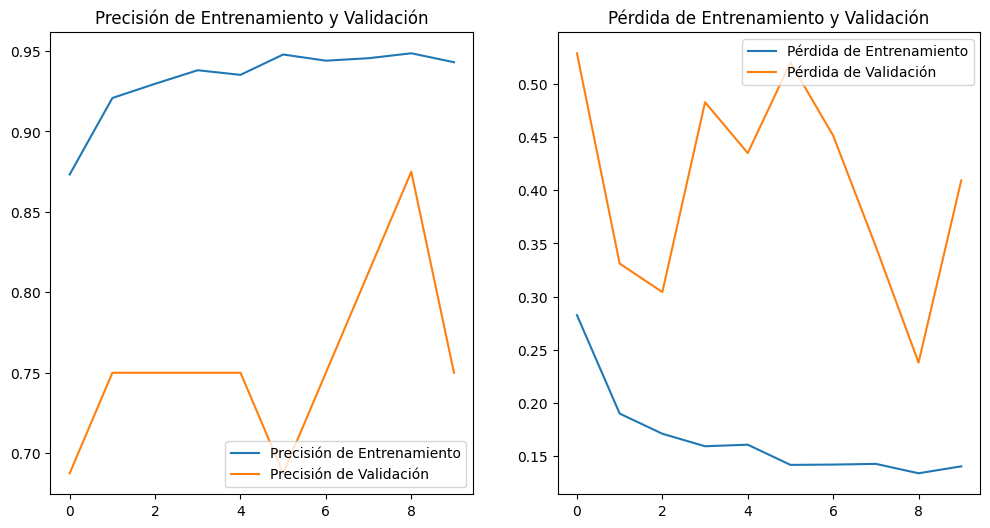

In [11]:
# Celda 7: Graficar la precisión y la pérdida del entrenamiento
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión de Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión de Validación')
plt.legend(loc='lower right')
plt.title('Precisión de Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida de Validación')
plt.legend(loc='upper right')
plt.title('Pérdida de Entrenamiento y Validación')
plt.show()

--- Evaluación Final en el Conjunto de Prueba ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 518ms/step - accuracy: 0.8631 - loss: 0.3774
Pérdida en Prueba: 0.2599
Precisión en Prueba: 0.9071
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 333ms/step


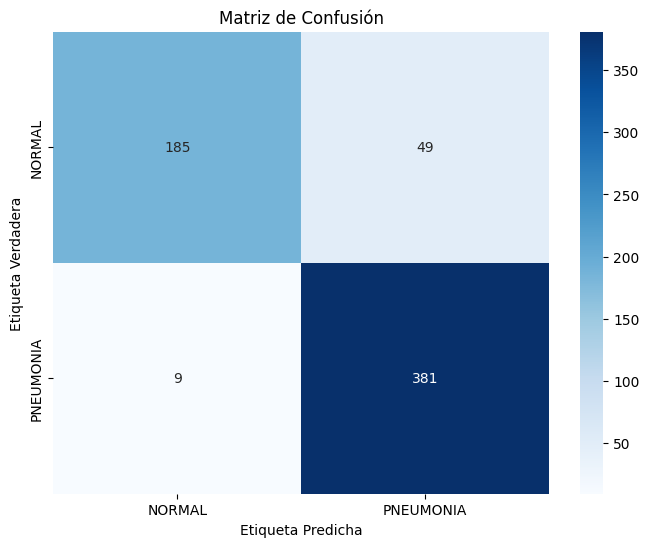


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

      NORMAL       0.95      0.79      0.86       234
   PNEUMONIA       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.90       624
weighted avg       0.91      0.91      0.90       624



In [12]:
# Celda 8: Evaluación final en el conjunto de prueba
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

print("--- Evaluación Final en el Conjunto de Prueba ---")
loss, accuracy = model.evaluate(test_generator)
print(f"Pérdida en Prueba: {loss:.4f}")
print(f"Precisión en Prueba: {accuracy:.4f}")

# Generar predicciones para crear la matriz de confusión
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).reshape(-1)

# --- Matriz de Confusión ---
# Es la parte más importante para la interpretación clínica
cm = confusion_matrix(test_generator.classes, y_pred)
class_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Verdadera')
plt.xlabel('Etiqueta Predicha')
plt.show()

# --- Reporte de Clasificación ---
print("\n--- Reporte de Clasificación ---")
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

In [13]:
# Celda 9: Guardar el modelo final en Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("Guardando el modelo en Google Drive...")
model.save('/content/drive/MyDrive/modelo_detector_neumonia_final.h5')
print("¡Modelo guardado exitosamente en tu Google Drive!")

Mounted at /content/drive
Guardando el modelo en Google Drive...
¡Modelo guardado exitosamente en tu Google Drive!
